### 分组测试经典方法
2022-07-17
- univ矩阵要求：所有值都没有缺失
2022-08-07
- 改成5元划分的两组
2022-08-16
- 通过bootstrap计算估计标准差
2022-09-03
- bootstrap计算分位点

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/18316/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Windows11/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester
""
from time import time

import warnings
warnings.filterwarnings("ignore")

In [8]:
with open(r"F:\Data\ML For Liquidity\raw_data_dic.pkl", 'rb') as f:
    data = pickle.load(f)

In [2]:
se = SpreadEstimator(market='SP500')

In [4]:
se.data.spread_dic.keys()

dict_keys(['spread', 'rela_spread', 'w_rela_spread'])

### 构造两组univ

In [8]:
univ = se.data.data_dic['volume'] > 0  # 当天有交易
th = 0.8

# univ_2 = []
# for i in range(2081):
#     if np.sum(se.data.data_dic['close'][univ[:,i],i]>10) >= th * 243:
#         univ_2.append(1)
#     else:
#         univ_2.append(0)
# univ_2 = np.array(univ_2) > 0
# print(np.sum(univ_2))
# univ_2 = np.repeat(univ_2.reshape(1,2081), 243, 0)

univ_1 = []
for i in range(492):
    if np.sum(se.data.data_dic['close'][univ[:,i],i]>5) >= th * 225:
        univ_1.append(1)
    else:
        univ_1.append(0)
univ_1 = np.array(univ_1) > 0
univ_1 = np.repeat(univ_1.reshape(1,492), 225, 0)
print(np.sum(univ_1[0]))

univ_0 = (~univ_1)
print(np.sum(univ_0[0]))

univ_0 = univ_0 & univ
univ_1 = univ_1 & univ

all_univ = [univ]

478
14


In [16]:
import pickle
with open(r"D:\Documents\学习资料\本科毕业论文\data\close_top.pkl", 'wb') as f:
    pickle.dump(univ_1, f)

### 在2组股票中测试

In [11]:
def test_cs(signal, target, univ, back: int = 1):
    corr = []
    for i in range(signal.shape[0]):
        if i < back-1:
            continue
        t = np.nanmean(target[i-back+1: i+1], axis=0)
        se = (~np.isnan(t)) & (~np.isnan(signal[i])) & univ[i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[i, se], t[se])[0, 1])
    print('{:.4f}'.format(np.nanmean(corr)))
    return corr

def test_ts(signal, target, univ, back: int = 1):
    corr = []
    new_t = np.zeros((len(target)-back+1, target.shape[1]))
    for i in range(new_t.shape[0]):
        new_t[i] = np.nanmean(target[i:i+back], axis=0)
    for i in range(signal.shape[1]):
        t = new_t[:, i]
        se = (~np.isnan(t)) & (~np.isnan(signal[back-1:, i])) & univ[back-1:, i]
        if np.sum(se) < 2:
            continue
        corr.append(np.corrcoef(signal[back-1:, i][se], t[se])[0, 1])
    print('{:.4f}'.format(np.nanmean(corr)))
    return corr

def cal_std(corr, num: int=10000):  # bootstrap计算标准差和分位点
    corr = np.array(corr)
    corr_ = []
    lst = [i for i in range(len(corr))]
    for n in range(10000):
        corr_.append(np.nanmean(corr[np.random.choice(lst, len(lst))]))
    corr_ = np.sort(corr_)
    print('{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(corr_[100], corr_[500],corr_[1000],corr_[9000],corr_[9500],corr_[9900]))
    return np.std(corr_)

In [6]:
def test_rela(signal, all_univ):
    print('rela cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['rela_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('rela ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['rela_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('vol_wtd_rel_bas cs ')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['w_rela_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('vol_wtd_rel_bas ts ')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['w_rela_spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
        
def test_spread(signal, all_univ):
    print('spread cs')
    for u in all_univ:
        _ = test_cs(signal, se.data.spread_dic['spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()
    print()

    print('spread ts')
    for u in all_univ:
        _ = test_ts(signal, se.data.spread_dic['spread'], u, 20)
        print('{:.4f}'.format(cal_std(_)))
        print()

In [7]:
np.random.seed(0)

#### HL

In [9]:
beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
print()

test_rela(signal, all_univ)

mean corr: 0.0643, positive_corr_ratio: 0.8592, corr_IR: 1.1347

rela cs
0.0500
0.0372, 0.0409, 0.0430, 0.0571, 0.0591, 0.0627
0.0055


rela ts
0.5904
0.5684, 0.5746, 0.5781, 0.6025, 0.6059, 0.6120
0.0095


vol_wtd_rel_bas cs 
0.1633
0.1490, 0.1530, 0.1553, 0.1714, 0.1737, 0.1783
0.0063


vol_wtd_rel_bas ts 
0.5388
0.5144, 0.5216, 0.5254, 0.5522, 0.5556, 0.5621
0.0104



In [68]:
beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'
high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')

print()
test_spread(signal, all_univ)

mean corr: 0.2196, positive_corr_ratio: 0.9272, corr_IR: 1.9186

spread cs
0.2335
0.2156, 0.2209, 0.2238, 0.2430, 0.2460, 0.2507
0.0075


spread ts
0.4613
0.4297, 0.4393, 0.4444, 0.4779, 0.4826, 0.4913
0.0132



#### Roll

In [12]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')

print()
test_rela(signal, all_univ)

mean corr: 0.1286, positive_corr_ratio: 0.7895, corr_IR: 0.7587

rela cs
0.1068
0.0758, 0.0846, 0.0890, 0.1251, 0.1305, 0.1416
0.0141


rela ts
0.6474
0.4805, 0.5382, 0.5674, 0.7175, 0.7305, 0.7543
0.0597


vol_wtd_rel_bas cs 
0.2209
0.1929, 0.2013, 0.2052, 0.2369, 0.2414, 0.2501
0.0123


vol_wtd_rel_bas ts 
0.6289
0.5135, 0.5491, 0.5690, 0.6854, 0.7001, 0.7241
0.0456



In [70]:
a = 'tsdelta{close,1}'
b = 'tsdelay{tsdelta{close,1},1}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
print()
test_spread(signal, all_univ)

mean corr: 0.6974, positive_corr_ratio: 1.0000, corr_IR: 2.5719

spread cs
0.7250
0.6839, 0.6966, 0.7029, 0.7479, 0.7539, 0.7653
0.0175


spread ts
0.4753
0.4440, 0.4531, 0.4578, 0.4922, 0.4970, 0.5063
0.0134



#### CHL

In [13]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')

print()
test_rela(signal, all_univ)

mean corr: 0.0837, positive_corr_ratio: 0.7670, corr_IR: 0.7529

rela cs
0.0583
0.0388, 0.0442, 0.0473, 0.0695, 0.0727, 0.0786
0.0086


rela ts
0.7490
0.7288, 0.7351, 0.7382, 0.7596, 0.7624, 0.7675
0.0084


vol_wtd_rel_bas cs 
0.1575
0.1375, 0.1436, 0.1467, 0.1686, 0.1716, 0.1778
0.0086


vol_wtd_rel_bas ts 
0.6712
0.6495, 0.6559, 0.6595, 0.6832, 0.6862, 0.6923
0.0092



In [72]:
a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
fml = 'prod{' + a + ',' + b + '}'
fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')

print()
test_spread(signal, all_univ)

mean corr: 0.1862, positive_corr_ratio: 1.0000, corr_IR: 1.9862

spread cs
0.4265
0.3838, 0.3951, 0.4014, 0.4509, 0.4583, 0.4723
0.0191


spread ts
0.5543
0.5243, 0.5335, 0.5380, 0.5708, 0.5753, 0.5846
0.0128



### bas

In [15]:
fml = 'last_rel_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')
print()
test_rela(signal, all_univ)

mean corr: 0.7343, positive_corr_ratio: 1.0000, corr_IR: 7.4584

rela cs
0.8742
0.8616, 0.8655, 0.8676, 0.8808, 0.8827, 0.8861
0.0052

0.4895
0.4781, 0.4816, 0.4833, 0.4957, 0.4973, 0.5007
0.0048


rela ts
0.1908
0.1565, 0.1671, 0.1723, 0.2095, 0.2147, 0.2236
0.0144

0.0767
0.0665, 0.0695, 0.0710, 0.0822, 0.0838, 0.0870
0.0044


vol_wtd_rel_bas cs 
0.8727
0.8605, 0.8642, 0.8661, 0.8794, 0.8811, 0.8844
0.0052

0.4873
0.4760, 0.4793, 0.4810, 0.4935, 0.4954, 0.4988
0.0049


vol_wtd_rel_bas ts 
0.1807
0.1449, 0.1564, 0.1619, 0.1997, 0.2053, 0.2155
0.0149

0.0749
0.0645, 0.0676, 0.0692, 0.0807, 0.0824, 0.0854
0.0045



In [16]:
fml = 'last_bas'

stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='relative_spread')

print()
test_spread(signal, all_univ)

mean corr: -0.0908, positive_corr_ratio: 0.0446, corr_IR: -2.3502

spread cs
0.2424
0.2216, 0.2277, 0.2309, 0.2541, 0.2574, 0.2639
0.0091

0.5423
0.5290, 0.5331, 0.5352, 0.5494, 0.5514, 0.5550
0.0056


spread ts
0.0131
0.0059, 0.0080, 0.0091, 0.0170, 0.0181, 0.0203
0.0031

0.0329
0.0279, 0.0293, 0.0301, 0.0357, 0.0364, 0.0378
0.0022



### Gibbs

In [14]:
path = r"C:\Users\Windows11\Desktop\Repositories\Low-Frequency-Spread-Estimator\estimator\cache_SP500"
gibbs = np.zeros((225, 492), dtype=np.float32)
for i in range(8):
    gibbs[20+21*i:41+21*i] = np.load('{}/{}.npy'.format(path, i))
i = 8
gibbs[20+21*i:] = np.load('{}/{}.npy'.format(path, i))

In [15]:
test_rela(gibbs, all_univ)

rela cs
-0.0019
-0.0091, -0.0068, -0.0059, 0.0020, 0.0032, 0.0053
0.0031


rela ts
0.0427
0.0362, 0.0382, 0.0392, 0.0461, 0.0471, 0.0490
0.0027


vol_wtd_rel_bas cs 
0.0003
-0.0075, -0.0052, -0.0040, 0.0047, 0.0060, 0.0083
0.0034


vol_wtd_rel_bas ts 
0.0031
-0.0038, -0.0019, -0.0008, 0.0069, 0.0080, 0.0099
0.0030



### LOT

In [16]:
import pickle
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\LOT.pkl", 'rb') as f:
    LOT = pickle.load(f)
    
test_rela(LOT[:,:,0], all_univ)

rela cs
0.0064
-0.0065, -0.0029, -0.0008, 0.0139, 0.0160, 0.0197
0.0057


rela ts
0.0681
0.0391, 0.0475, 0.0520, 0.0841, 0.0884, 0.0967
0.0125


vol_wtd_rel_bas cs 
0.0216
0.0121, 0.0149, 0.0164, 0.0270, 0.0285, 0.0316
0.0041


vol_wtd_rel_bas ts 
0.0769
0.0481, 0.0563, 0.0608, 0.0930, 0.0975, 0.1058
0.0125



In [17]:
import pickle
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\LOT.pkl", 'rb') as f:
    LOT = pickle.load(f)
    
test_rela(LOT[:,:,1], all_univ)

rela cs
0.0267
0.0101, 0.0149, 0.0175, 0.0361, 0.0388, 0.0443
0.0073


rela ts
0.2278
0.2008, 0.2087, 0.2127, 0.2427, 0.2469, 0.2545
0.0116


vol_wtd_rel_bas cs 
0.0891
0.0752, 0.0790, 0.0812, 0.0972, 0.0997, 0.1040
0.0062


vol_wtd_rel_bas ts 
0.2321
0.2072, 0.2145, 0.2182, 0.2460, 0.2500, 0.2574
0.0108



### 查看10元以上组合的市值占比

In [70]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
ave_cap = np.nanmean(se.data.data_dic['cap'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.12534970276961246
0.196356803394121
0.6782934938362665


In [69]:
ave_cap = np.nanmean(se.data.data_dic['volume']*se.data.data_dic['close'], axis=0)
print(np.sum(ave_cap[np.sum(univ_0, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_1, axis=0)>0])/np.sum(ave_cap))
print(np.sum(ave_cap[np.sum(univ_2, axis=0)>0])/np.sum(ave_cap))

0.15209941578100805
0.2337683401885248
0.6141322440304672


In [68]:
print(np.sum(np.sum(univ_0, axis=0)>0))
print(np.sum(np.sum(univ_1, axis=0)>0))
print(np.sum(np.sum(univ_2, axis=0)>0))

532
695
854


### 绘制相对价差和收盘价的散点图

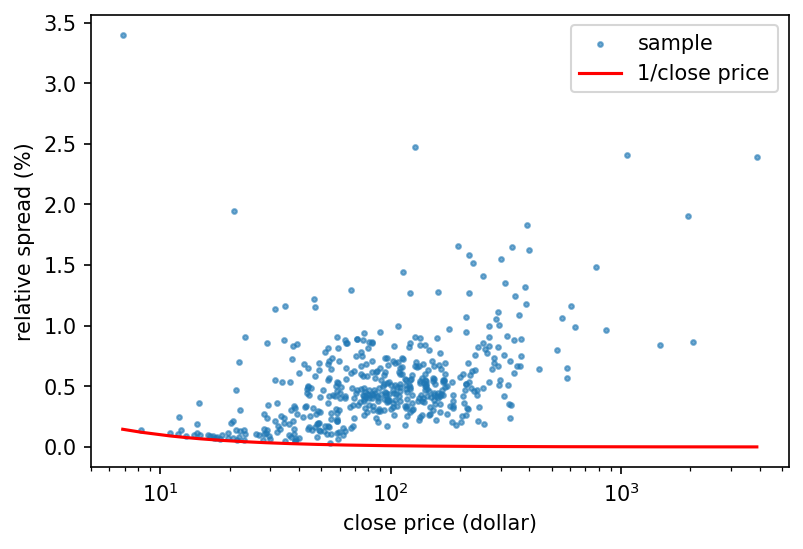

In [34]:
plt.figure(figsize=(6,3.92), dpi=150)
plt.scatter(se.data.data_dic['close'][24, univ[24]], 
            se.data.spread_dic['rela_spread'][24, univ[24]]*100, alpha=0.6, s=5, label='sample')
x = np.sort(se.data.data_dic['close'][24, univ[24]])
plt.plot(x, 1/x, alpha=1, color='r',label='1/close price')
plt.legend()
plt.xlabel('close price (dollar)')
plt.ylabel('relative spread (%)')
plt.xscale('log')
plt.show()

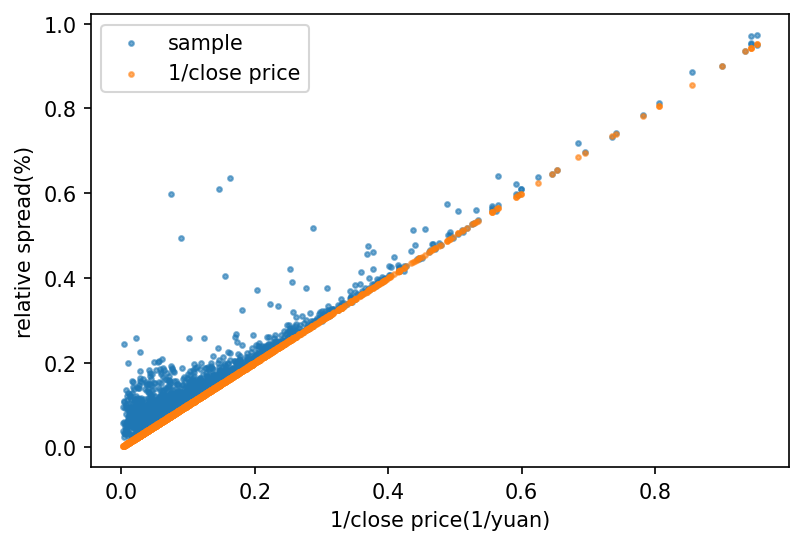

In [61]:
plt.figure(dpi=150)
plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            se.data.spread_dic['relative_spread'][242, univ[242]]*100, alpha=0.6, s=5, label='sample')
plt.scatter(1/se.data.data_dic['close'][242, univ[242]], 
            1/se.data.data_dic['close'][242, univ[242]], alpha=0.6, s=5, label='1/close price')
plt.legend()
plt.legend()
plt.xlabel('1/close price(1/yuan)')
plt.ylabel('relative spread(%)')
plt.show()

In [16]:

fml = 'tsmean{logv{close},20}'
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')

print()
test_rela(signal, all_univ)

mean corr: 0.4856, positive_corr_ratio: 1.0000, corr_IR: 2.6440

rela cs
-0.2518
-0.2874, -0.2775, -0.2721, -0.2313, -0.2250, -0.2132
0.0159

0.6127
0.5841, 0.5924, 0.5973, 0.6283, 0.6327, 0.6399
0.0121


rela ts
-0.3043
-0.6504, -0.5542, -0.4991, -0.1011, -0.0410, 0.0647
0.1550

-0.5248
-0.5460, -0.5398, -0.5366, -0.5132, -0.5099, -0.5029
0.0091




### Dump training data

In [20]:
import h5py
path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"

def get_signal_rela(se):  # 得到以relative spread为目标的signal
    sig = {}
    # HL
    beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

    high_1 = 'logv{tsdelay{high,1}}'
    low_1 = 'logv{tsdelay{low,1}}'
    con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
    con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
    con = 'add{' + con_1 + ',' + con_2 + '}'
    high_2 = 'minus{logv{high},' + con + '}'
    low_2 = 'minus{logv{low},' + con + '}'
    high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
    low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

    gamma = 'powv{minus{' + high + ',' + low + '},2}'
    alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
    fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

    fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'

    fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['HL'] = signal

    # Roll
    a = 'tsdelta{logv{close},1}'
    b = 'tsdelay{tsdelta{logv{close},1},1}'
    fml = 'prod{' + a + ',' + b + '}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    fml = 'powv{' + fml + ',0.5}'

    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['ROLL'] = signal

    # CHL
    a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
    b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
    fml = 'prod{' + a + ',' + b + '}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    fml = 'powv{' + fml + ',0.5}'

    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['CHL'] = signal
    
    fml = 'tsmean{logv{open},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['open'] = signal
    
    fml = 'tsmean{logv{close},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['close'] = signal
    
    fml = 'tsmean{logv{high},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['high'] = signal

    fml = 'tsmean{logv{low},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['low'] = signal
    
    fml = 'tsmean{logv{volume},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['volume'] = signal
    
    fml = 'tsmean{logv{cap},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['cap'] = signal
    
    with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\LOT.pkl", 'rb') as f:
        LOT = pickle.load(f)
        
    path = r"C:\Users\Windows11\Desktop\Repositories\Low-Frequency-Spread-Estimator\estimator\cache_SP500"
    gibbs = np.zeros((225, 492), dtype=np.float32)
    for i in range(8):
        gibbs[20+21*i:41+21*i] = np.load('{}/{}.npy'.format(path, i))
    i = 8
    gibbs[20+21*i:] = np.load('{}/{}.npy'.format(path, i))

    signal = np.zeros((sig['HL'].shape[0], sig['HL'].shape[1], 12), dtype=np.float32)
    signal[:, :, 0] = sig['CHL']
    signal[:, :, 1] = sig['HL']
    signal[:, :, 2] = sig['ROLL']
    signal[:, :, 3] = LOT[:, :, 0]
    signal[:, :, 4] = LOT[:, :, 1]
    signal[:, :, 5] = gibbs[:]
    
    signal[:, :, 6] = sig['open']
    signal[:, :, 7] = sig['close']
    signal[:, :, 8] = sig['high']
    signal[:, :, 9] = sig['low']
    signal[:, :, 10] = sig['volume']
    signal[:, :, 11] = sig['cap']
    return signal

def get_target(se, name: str = 'rela_spread'):  # 得到target
    rel_sp = se.data.spread_dic['rela_spread'].copy()
    back = 20
    for i in range(rel_sp.shape[0]):
        if i < back - 1:
            rel_sp[i] = np.nan
        else:
            rel_sp[i] = np.nanmean(se.data.spread_dic[name][i - back + 1:i + 1], axis=0)
    return rel_sp

In [21]:
signal_rela = get_signal_rela(se)
target_rela = get_target(se, 'rela_spread')

mean corr: 0.0643, positive_corr_ratio: 0.8592, corr_IR: 1.1347
mean corr: 0.1286, positive_corr_ratio: 0.7895, corr_IR: 0.7587
mean corr: 0.0837, positive_corr_ratio: 0.7670, corr_IR: 0.7529
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan


In [22]:
import pickle
signal_rela = get_signal_rela(se)
target_rela = get_target(se, 'rela_spread')
path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"
with open(f'{path}/signal_rela.pkl', 'wb') as f:
    pickle.dump(signal_rela, f)
    
with open(f'{path}/target_rela.pkl', 'wb') as f:
    pickle.dump(target_rela, f)

In [18]:
import h5py
path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"

def get_signal_spread(se):  # 得到以relative spread为目标的signal
    sig = {}
    # HL
    beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'
    high_1 = 'tsdelay{high,1}'
    low_1 = 'tsdelay{low,1}'
    con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
    con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
    con = 'add{' + con_1 + ',' + con_2 + '}'
    high_2 = 'minus{high,' + con + '}'
    low_2 = 'minus{low,' + con + '}'
    high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
    low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

    gamma = 'powv{minus{' + high + ',' + low + '},2}'
    alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
    fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

    fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
    sig['HL'] = signal

    # Roll
    a = 'tsdelta{close,1}'
    b = 'tsdelay{tsdelta{close,1},1}'
    fml = 'prod{' + a + ',' + b + '}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    fml = 'powv{' + fml + ',0.5}'

    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread')
    sig['ROLL'] = signal

    # CHL
    a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
    b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
    fml = 'prod{' + a + ',' + b + '}'
    fml = 'condition{' + 'ge{' + fml + ',0},' + fml + ',add{minus{close,close},0}}'
    fml = 'tsmean{' + fml + ',20}'
    fml = 'powv{' + fml + ',0.5}'

    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['CHL'] = signal
    
    fml = 'tsmean{logv{open},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['open'] = signal
    
    fml = 'tsmean{logv{close},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['close'] = signal
    
    fml = 'tsmean{logv{high},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['high'] = signal

    fml = 'tsmean{logv{low},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['low'] = signal
    
    fml = 'tsmean{logv{volume},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['volume'] = signal
    
    fml = 'tsmean{logv{cap},20}'
    stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='rela_spread')
    sig['cap'] = signal
    
    with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\LOT.pkl", 'rb') as f:
        LOT = pickle.load(f)
        
    path = r"C:\Users\Windows11\Desktop\Repositories\Low-Frequency-Spread-Estimator\estimator\cache_SP500"
    gibbs = np.zeros((225, 492), dtype=np.float32)
    for i in range(8):
        gibbs[20+21*i:41+21*i] = np.load('{}/{}.npy'.format(path, i))
    i = 8
    gibbs[20+21*i:] = np.load('{}/{}.npy'.format(path, i))

    signal = np.zeros((sig['HL'].shape[0], sig['HL'].shape[1], 12), dtype=np.float32)
    signal[:, :, 0] = sig['CHL']
    signal[:, :, 1] = sig['HL']
    signal[:, :, 2] = sig['ROLL']
    signal[:, :, 3] = LOT[:, :, 0]
    signal[:, :, 4] = LOT[:, :, 1]
    signal[:, :, 5] = gibbs[:]
    
    signal[:, :, 6] = sig['open']
    signal[:, :, 7] = sig['close']
    signal[:, :, 8] = sig['high']
    signal[:, :, 9] = sig['low']
    signal[:, :, 10] = sig['volume']
    signal[:, :, 11] = sig['cap']
    return signal

def get_target(se, name: str = 'rela_spread'):  # 得到target
    rel_sp = se.data.spread_dic[name].copy()
    back = 20
    for i in range(rel_sp.shape[0]):
        if i < back - 1:
            rel_sp[i] = np.nan
        else:
            rel_sp[i] = np.nanmean(se.data.spread_dic[name][i - back + 1:i + 1], axis=0)
    return rel_sp

In [4]:
import pickle
signal_rela = get_signal_spread(se)
target_rela = get_target(se, 'spread')
path = r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity"
with open(f'{path}/signal_spread.pkl', 'wb') as f:
    pickle.dump(signal_rela, f)
    
with open(f'{path}/target_spread.pkl', 'wb') as f:
    pickle.dump(target_rela, f)

mean corr: 0.2213, positive_corr_ratio: 0.9272, corr_IR: 1.9196
mean corr: 0.6957, positive_corr_ratio: 1.0000, corr_IR: 2.5659
mean corr: 0.1914, positive_corr_ratio: 1.0000, corr_IR: 2.0066
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan
mean corr: nan, positive_corr_ratio: nan, corr_IR: nan


In [19]:
target_rela = get_target(se, 'w_rela_spread')
with open(f'{path}/target_wrela.pkl', 'wb') as f:
    pickle.dump(target_rela, f)

### 测试两个meta并起来

In [26]:
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\dump_signal\out_2.pkl", 'rb') as f:
    out_2 = pickle.load(f)
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\dump_signal\out_1.pkl", 'rb') as f:
    out_1 = pickle.load(f)
with open(r"C:\Users\Windows11\Desktop\ML_data\ML4Liquidity\dump_signal\ys.pkl", 'rb') as f:
    ys = pickle.load(f)

In [27]:
corr = []
for i in range(len(out_2)):
    tmp = out_1[i] + out_2[i]*0.5
    y = ys[i]
    corr.append(np.corrcoef(tmp, y)[0, 1])
print(np.mean(corr))

0.7143367283312537


In [20]:
len(tmp)

203

In [21]:
len(y)

203

In [22]:
np.corrcoef(tmp, y)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 203 and the array at index 1 has size 492

In [24]:
y.shape

(203, 492)

In [25]:
tmp.shape

(203,)